<a href="https://colab.research.google.com/github/Raashidh-Rizvi/Brain-Tumor-Detection/blob/main/notesbooks/%20IT24103178_Noise_Outlier_Removal_%26_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'Brain-Tumor-Detection'...
remote: Enumerating objects: 6771, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6771 (delta 2), reused 2 (delta 0), pack-reused 6760 (from 3)
Receiving objects: 100% (6771/6771), 142.31 MiB | 24.31 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (7025/7025), done.
Total images found: 5712
Global PCA components set to 11 (min of 50, 11, 16384)
Processing batch 1 (100 images)
  Loaded 100 images
  After outlier removal: 96 images
Processing batch 2 (100 images)
  Loaded 100 images
  After outlier removal: 99 images
Processing batch 3 (100 images)
  Loaded 100 images
  After outlier removal: 98 images
Processing batch 4 (100 images)
  Loaded 100 images
  After outlier removal: 98 images
Processing batch 5 (100 images)
  Loaded 100 images
  After outlier removal: 99 images
Processing batch 6 (100 images)
  Loaded 100 images
  After outlier removal: 100 images
Pr

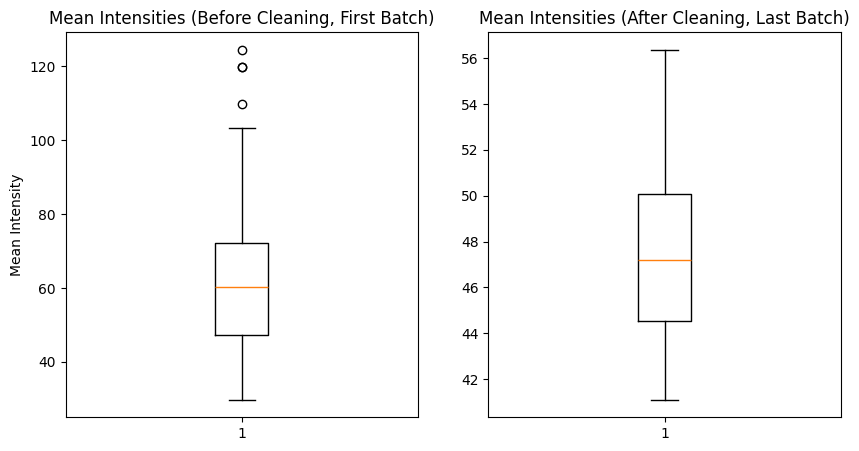

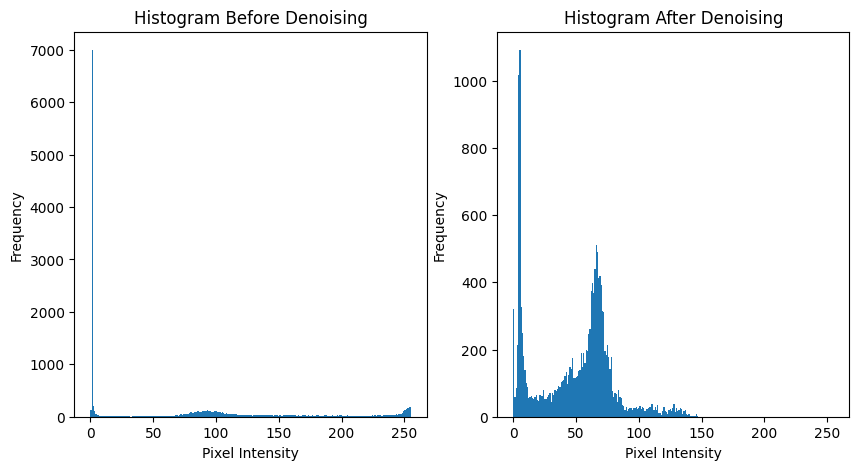

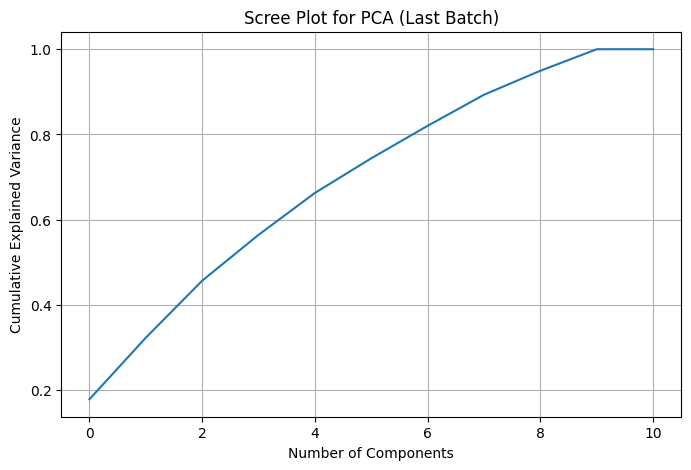

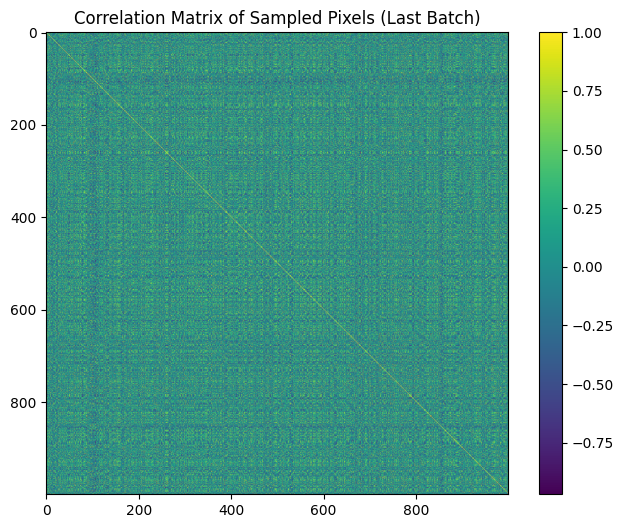

In [ ]:
# Install required libraries
!pip install opencv-python scikit-image

# Clone the GitHub repository (if not already cloned)
!git clone https://github.com/Raashidh-Rizvi/Brain-Tumor-Detection.git

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import exposure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gc  # For memory management

# Define directories
train_dir = "/content/Brain-Tumor-Detection/data/Training"
output_dir = "/content/cleaned_images"
os.makedirs(output_dir, exist_ok=True)  # Directory to save cleaned images

# Load image paths (Training set)
image_paths = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))
print(f"Total images found: {len(image_paths)}")

# Preprocessing Pipeline with Batch Processing
def preprocess_pipeline(image_paths, target_size=(128, 128), desired_pca_components=50, batch_size=100):

    reduced_data = []
    cleaned_images = []
    flattened_images = None
    variance_ratio = None

    # First pass: Determine minimum number of samples across batches
    min_samples = float('inf')
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        images = [cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), target_size)
                  for path in batch_paths if cv2.imread(path) is not None]
        if not images:
            continue
        denoised = [cv2.medianBlur(img, 3) for img in images]
        means = [np.mean(img) for img in denoised]
        df = pd.DataFrame({'mean': means})
        Q1, Q3 = df['mean'].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        cleaned = [denoised[i] for i in df[(df['mean'] >= Q1 - 1.5*IQR) &
                                          (df['mean'] <= Q3 + 1.5*IQR)].index]
        if cleaned:
            min_samples = min(min_samples, len(cleaned))
        del images, denoised, cleaned
        gc.collect()

    # Set PCA components based on smallest batch
    n_features = target_size[0] * target_size[1]
    pca_components = min(desired_pca_components, min_samples, n_features)
    print(f"Global PCA components set to {pca_components} (min of {desired_pca_components}, {min_samples}, {n_features})")

    # Second pass: Process batches with fixed PCA components
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1} ({len(batch_paths)} images)")

        # Load and resize images
        images = [cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), target_size)
                  for path in batch_paths if cv2.imread(path) is not None]
        print(f"  Loaded {len(images)} images")

        # Noise removal (median filter)
        denoised = [cv2.medianBlur(img, 3) for img in images]

        # Outlier removal (IQR on mean intensity)
        means = [np.mean(img) for img in denoised]
        df = pd.DataFrame({'mean': means})
        Q1, Q3 = df['mean'].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        cleaned = [denoised[i] for i in df[(df['mean'] >= Q1 - 1.5*IQR) &
                                          (df['mean'] <= Q3 + 1.5*IQR)].index]
        print(f"  After outlier removal: {len(cleaned)} images")

        # Save cleaned images to disk
        for j, img in enumerate(cleaned):
            cv2.imwrite(os.path.join(output_dir, f"cleaned_{i+j}.jpg"), img)

        # Store cleaned images for EDA (last batch only)
        cleaned_images = cleaned

        # Flatten and standardize for PCA
        flattened = np.array([img.flatten() for img in cleaned])
        if len(flattened) == 0:
            print("  No images after outlier removal; skipping batch")
            continue

        scaler = StandardScaler()
        scaled = scaler.fit_transform(flattened)

        # Apply PCA with fixed components
        pca = PCA(n_components=pca_components)
        batch_reduced = pca.fit_transform(scaled)

        # Store results
        reduced_data.append(batch_reduced)
        variance_ratio = pca.explained_variance_ratio_  # From last valid batch
        flattened_images = flattened  # For EDA, last batch

        # Clear memory
        del images, denoised, scaled, batch_reduced
        gc.collect()

    # Concatenate reduced data
    reduced_data = np.vstack(reduced_data) if reduced_data else np.array([])
    print(f"Final reduced shape: {reduced_data.shape}")

    return reduced_data, variance_ratio, cleaned_images, flattened_images

# Run pipeline (process all images with batch_size=100)
reduced_data, var_ratio, cleaned_images, flattened_images = preprocess_pipeline(image_paths, batch_size=100)

# EDA for Outlier/Noise Removal
# Boxplot (using first batch for "before")
first_batch_paths = image_paths[:100]
mean_intensities_before = [np.mean(cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (128, 128)))
                           for path in first_batch_paths if cv2.imread(path) is not None]
mean_intensities_after = [np.mean(img) for img in cleaned_images]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(mean_intensities_before)
plt.title('Mean Intensities (Before Cleaning, First Batch)')
plt.ylabel('Mean Intensity')

plt.subplot(1, 2, 2)
plt.boxplot(mean_intensities_after)
plt.title('Mean Intensities (After Cleaning, Last Batch)')
plt.show()

# Histogram for noise (sample image from last batch)
sample_idx = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(cv2.resize(cv2.imread(first_batch_paths[sample_idx], cv2.IMREAD_GRAYSCALE), (128, 128)).ravel(),
         bins=256, range=(0, 255))
plt.title('Histogram Before Denoising')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(cleaned_images[sample_idx].ravel(), bins=256, range=(0, 255))
plt.title('Histogram After Denoising')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# EDA for Dimensionality Reduction
# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(var_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA (Last Batch)')
plt.grid(True)
plt.show()

# Correlation Matrix (sample 1000 pixels to avoid RAM issues)
n_pixels = 1000
random_pixels = np.random.choice(flattened_images.shape[1], size=n_pixels, replace=False)
subset_data = flattened_images[:10, random_pixels]
corr_matrix = pd.DataFrame(subset_data).corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis')
plt.title('Correlation Matrix of Sampled Pixels (Last Batch)')
plt.colorbar()
plt.show()